In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

#import pyphysio
import pyphysio as ph
import pandas as pd
import pyphysio.filters.Filters as flt

# (should) show plots in a separate window
%matplotlib inline

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [2]:
# open 2nd September file
df_EDA = pd.read_csv('EDA_pp36.csv', header=None)

# create the signal
fsamp = 4 #Hz
tstart_df_EDA = 100 #s


eda = ph.EvenlySignal(values = df_EDA.values.ravel(), 
                      sampling_freq = fsamp,
                      start_time = tstart_df_EDA)

In [3]:
#count n of rows to get time of recording (s) 
n_of_rows = df_EDA.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/4
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

# save data 
outputFile=open("time_pp36.txt", 'a')
outputFile.write("{}\n{}\n".format(walk_time_seconds, walk_time_minutes))
outputFile.close()


0    13980
dtype: int64
0    3495.0
dtype: float64
0    58.25
dtype: float64


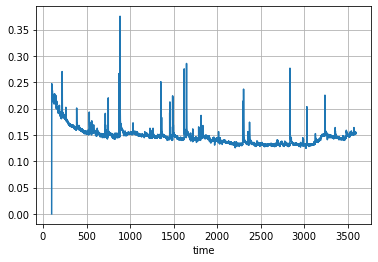

In [4]:
# plot
plot = eda.plot()
# plt.show() #using matplotlib to show the plot

In [5]:
#your signal is quite noisy (moving artifacts)
#consider the possibility of filtering it

#e.g. simple moving average filter
mov_avg = flt.ConvolutionalFilter('rect', win_len = 1)
eda = mov_avg(eda)

#however, check that you are not losing information


In [6]:
#create baseline (10mins) / label variable
#[0s-600s] #baseline 
#[600s -3480s] #actual recording session 

label = np.zeros(3495)#s
label[0:600] = 1
label[600:3495] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label')

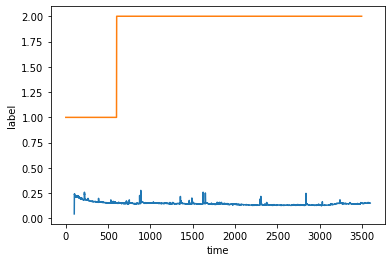

In [7]:
#see also the plots
eda.plot()
label.plot()

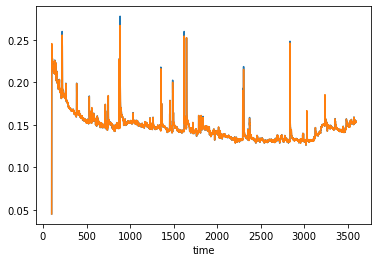

In [8]:
## filtering 
eda_filt = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda)

eda.plot()
eda_filt.plot()

In [9]:
eda = eda_filt

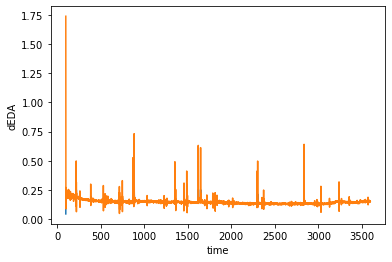

In [10]:

## estimate the driver function 
driver = ph.DriverEstim(t1=.75, t2=2)(eda)
eda.plot()
driver.plot()

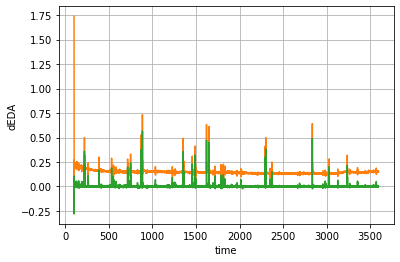

In [11]:
## compute tonic and phasic components
phasic, tonic, tmp_ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot()
driver.plot()
phasic.plot()

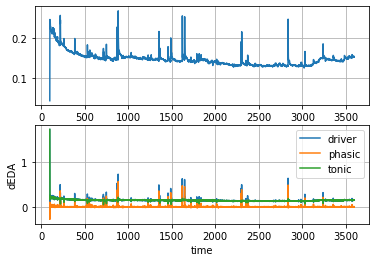

In [12]:
# check results so far
plt.figure() 
ax1 = plt.subplot(211)
eda.plot()
plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
tonic.plot()
plt.legend(['driver', 'phasic', 'tonic'])
plt.show()

This is not needed as you are defining the indicators in the next cell

```python
## import indicators library
#import pyphysio.indicators.TimeDomain as td_ind #<- NOT needed as all indicators are already available in the userspace

## create an indicator
Mean = ph.Mean() #use ph instead of td_ind
StDev = ph.StDev()
AUC = ph.AUC()
PeaksMean = ph.PeaksMean(delta = 0.02)
DurMean = ph.DurationMean(delta=0.02)

Mean_ = Mean(eda) #<-- WHY THIS?
```

In [13]:
## define a list of indicators
indicators_eda = [ph.Mean(name='PhaMean'),
                  ph.StDev(name='StDev'),
                  ph.AUC(name='AUC'),
                  ph.PeaksMean(name='PeaksMean', delta=0.02), #YOU WERE MISSING A COMMA HERE
                  ph.DurationMean(name='DurMean', delta=0.02)]

# you can also use other indicators, however, my suggestion would be to keep it simple and use the usual ones (mean, maximum, range etc)

In [14]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 20, labels = label) #giving me error                
                  
## compute indicators of phasic signal
#pha_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic) #you should use the indicators you listed before
pha_ind, col_names = ph.fmap(fixed_length, indicators_eda, phasic) #you should use the indicators you listed before

In [15]:
#save results into a dataframe
phasic_indicators = pd.DataFrame(pha_ind, columns=col_names)

In [16]:
phasic_indicators.head()

,begin,end,label,PhaMean,StDev,AUC,PeaksMean,DurMean
0,100.0,120.0,1.0,-0.003597,0.057652,-0.071934,0.045929,1.312500
1,105.0,125.0,1.0,0.007168,0.013223,0.143365,0.043366,1.333333
2,110.0,130.0,1.0,0.003357,0.010895,0.067145,0.055780,1.500000
3,115.0,135.0,1.0,0.005798,0.012714,0.115961,0.038920,1.500000
4,120.0,140.0,1.0,0.007964,0.014866,0.159289,0.030540,1.500000


```python
# This is from the example, you will not need it unless you want to compare the baseline v. experiment
# but you will need to change the code
## Box-Whisker plot
# extract column with the labels for each window
#label_w = pha_ind[:, np.where(col_names == 'label')[0]]
            
# extract column with PksMean values
# computed from each window
#pksmean_w = pha_ind[:, np.where(col_names == 'PeaksMean')[0]]

#pksmean_image1 = pksmean_w[np.where(label_w==1)[0]]
#pksmean_image2 = pksmean_w[np.where(label_w==2)[0]]

## create a boxplot and a whisker plot
## compare the distribution of the RRmean indicator
#plt.boxplot([pksmean_image1, pksmean_image2],
              labels=['image1', 'imag2e'])

##plt.show()
            

# create a pandas dataframe (exporting files)
#pha_ind_df = pd.DataFrame(pha_ind_df, columns=col_names)
#pha_ind_df
```
phasic_indicators.to_csv('phasicindicators.csv')


            

In [17]:
phasic_indicators.to_csv('phasicindicators_pp36.csv')

c:\users\sale\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
c:\users\sale\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
c:\users\sale\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
c:\users\sale\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


{'whiskers': [<matplotlib.lines.Line2D at 0x11ed08f0>,
 'caps': [<matplotlib.lines.Line2D at 0x11dc79d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11ed07d0>,
 'medians': [<matplotlib.lines.Line2D at 0x11efe670>,
 'fliers': [<matplotlib.lines.Line2D at 0x11efe8d0>,
 'means': []}

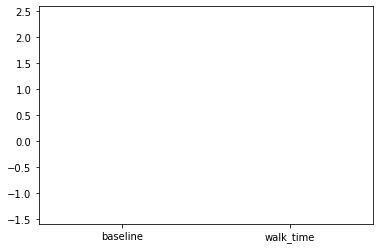

In [18]:
## Box-Whisker plot
# extract column with the labels for each window
label_w = pha_ind[:, np.where(col_names == 'label')[0]]

# extract column with PksMean values
# computed from each window
pksmean_w = pha_ind[:, np.where(col_names == 'PeaksMean')[0]]

pksmean_baseline = pksmean_w[np.where(label_w==1)[0]]
pksmean_walk_time = pksmean_w[np.where(label_w==2)[0]]

## create a boxplot and a whisker plot
## compare the distribution of the RRmean indicator
plt.boxplot([pksmean_baseline, pksmean_walk_time],
              labels=['baseline', 'walk_time'])

##plt.show()